# Project Overview

The goal of this project is to segment customers for TravelTide, an e-booking travel startup, in order to support the development of a personalized rewards program.

**Project Recap**

* Extracted data from the TravelTide PostgreSQL database.

* Focused on a session-level dataset and selected 50,000 random sessions.

* This notebook continues the exploration of session behavior, forming the analytical foundation for cohort analysis and segmentation.


**Notebook Overview**

This notebook focuses on understanding user behavior through session data.

This EDA helps uncover anomalies and patterns in user engagement. This notebook serves as a guide to the later cohort definitions and clustering approaches.


# Key Insights

**Session Duration & Page Clicks:**

* Most users have very brief sessions (under 500 seconds) with few page clicks (under 25 clicks)
* The distribution is heavily right-skewed for both metrics

There's an unusual pattern between `session_duration` and `page_clicks`, showing three distinct clusters of session behaviors:

* A steep linear relationship between clicks and short sessions
* A more gradual linear trend for medium-length sessions
* A vertical cluster at approximately 7e12 session duration (likely an anomaly or logging error)


**Booking Behaviors:**

* About 37% of users book flights, while 63% don't
* Hotel booking rate is slightly higher, at approximately 40%
* This suggests a significant portion of visitors are browsing but not converting

**User Demographics:**

* `Gender`: Fairly balanced between male and female users, with a very small "Other" category
* `Marital Status`: About 60% are unmarried, 40% are married
* `Parental Status`: About 70% don't have children, 30% do
* These demographics suggest the platform attracts a diverse audience, with a slight skew toward single users without children

**Home City Distribution:**

* New York dominates as the most common home city (nearly 6000 users)
* Los Angeles, is second with about half the users of New York
* The top 10 includes major North American cities (New York, Los Angeles, Toronto, Chicago, Houston, Montreal, Philadelphia, Phoenix, San Diego, San Antonio)
* This suggests the platform has a strong presence in major metropolitan areas

**Travel Patterns**

* Room & Luggage Relationships:

   * No strong correlation between the number of `rooms` and `checked bags`
   * The most common pattern is 1-2 bags, regardless of room count
   * Length of stay (nights) shows more variability in baggage requirements


* Room & Seat Relationship:

   * Positive correlation between `rooms` booked and `seats` required
   * Larger groups (5+ seats) tend to book 4-5 rooms
   * This logically reflects group size, influencing both metrics


**Pricing & Discounts**

  * `Flight discounts` range primarily between 5-20%, with the most frequent being around 10%
  * `Hotel discounts` show a similar distribution, clustering between 5-15%
  * Approximately 20% of users receive `flight discounts`
  * Only about 15% receive `hotel discounts`
  * Higher `base fares` (>$4000) tend to receive lower percentage discounts
  * Hotel discounts follow a similar pattern, decreasing at higher room rates


# Libraries and Data

We begin by loading the session dataset and checking for its shape, column names, missing values, and data types to ensure readiness for analysis.

* There are missing values in multiple columns
* There is a duplicate column for page_clicks
* There are no duplicate rows
* There are no duplicate rows
* The data has 43 features
* The average session duration is 215 seconds with 19 average page clicks
* The average flight discount is 14% and the average hotel discount is 11%
* The average nights are 5 with 1 room

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
sessions = pd.read_csv('/content/session_based_eda.csv')

In [ ]:
print('Rows and Columns:', sessions.shape)

Rows and Columns: (50000, 43)


In [ ]:
sessions.head()

,session_id,user_id,trip_id,session_start,session_end,session_duration,page_clicks,flight_discount,flight_discount_amount,hotel_discount,...,trip_airline,destination_airport_lat,destination_airport_lon,base_fare_usd,hotel_name,nights,rooms,check_in_time,check_out_time,hotel_per_room_usd
0,540008-2eee158fbf2842e883b57f92101bd4e9,540008,NaN,2023-01-19 19:03:00,2023-01-19 19:04:43,103.0,13,False,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,45681-b77c5ba2e919436c97687b7430065acd,45681,NaN,2021-11-25 17:09:00,2021-11-25 17:09:30,30.0,4,False,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,638019-f0368e1584644fe08d7f330545e8829c,638019,NaN,2023-06-26 16:53:00,2023-06-26 16:57:53,293.0,39,False,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,429475-9cf219e93523497ea6309b1c2f4f6bc0,429475,429475-042fd3d9228b45ef83a6f4c01a5f653f,2022-11-23 16:00:00,2022-11-23 16:02:13,133.0,18,False,NaN,False,...,Southwest Airlines,32.166,-110.883,255.99,Crowne Plaza - tucson,3.0,1.0,2022-12-02 17:54:25.83,2022-12-05 11:00:00,32.0
4,888779-0ef425ef111243cca8f1d9fda9906d29,888779,888779-f6a690bee1aa47a2a6d0e61b378174cf,2023-06-18 14:03:00,2023-06-18 14:05:23,143.0,19,False,NaN,False,...,United Airlines,33.535,-112.383,577.70,Fairmont - phoenix,4.0,1.0,2023-06-27 14:13:29.28,2023-07-01 11:00:00,381.0


In [ ]:
sessions.describe()

,user_id,session_duration,page_clicks,flight_discount_amount,hotel_discount_amount,page_click,home_airport_lat,home_airport_lon,seats,checked_bags,destination_airport_lat,destination_airport_lon,base_fare_usd,nights,rooms,hotel_per_room_usd
count,5.000000e+04,50000.000000,50000.000000,8215.000000,6295.000000,50000.000000,50000.000000,50000.000000,18440.000000,18440.000000,18440.000000,18440.000000,18440.000000,18181.000000,18181.000000,18181.000000
mean,3.981443e+05,215.302714,18.809600,0.139136,0.110802,18.809600,38.562893,-93.972287,1.283785,0.626735,37.927423,-80.538835,717.558164,5.012596,1.191464,175.097024
std,2.711369e+05,756.477887,22.292179,0.084466,0.062626,22.292179,6.136400,18.156566,0.690516,0.756332,8.607023,49.253304,1244.373152,4.428345,0.483872,112.546271
min,2.600000e+01,7.000000,1.000000,0.050000,0.050000,1.000000,21.316000,-157.927000,0.000000,0.000000,-37.008000,-157.927000,0.000000,1.000000,1.000000,17.000000
25%,1.626242e+05,52.000000,7.000000,0.100000,0.050000,7.000000,33.942000,-112.383000,1.000000,0.000000,33.535000,-112.383000,208.225000,2.000000,1.000000,98.000000
50%,3.645360e+05,112.000000,15.000000,0.100000,0.100000,15.000000,39.297000,-89.977000,1.000000,1.000000,39.858000,-87.752000,407.000000,4.000000,1.000000,147.000000
75%,6.022250e+05,170.000000,23.000000,0.200000,0.150000,23.000000,42.276000,-77.456000,1.000000,1.000000,42.409000,-73.779000,664.057500,6.000000,1.000000,219.000000
max,1.020739e+06,7200.000000,287.000000,0.650000,0.500000,287.000000,61.251000,-63.499000,10.000000,9.000000,58.789000,174.792000,21853.210000,91.000000,5.000000,1468.000000


In [ ]:
sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 43 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   session_id               50000 non-null  object 
 1   user_id                  50000 non-null  int64  
 2   trip_id                  21681 non-null  object 
 3   session_start            50000 non-null  object 
 4   session_end              50000 non-null  object 
 5   session_duration         50000 non-null  float64
 6   page_clicks              50000 non-null  int64  
 7   flight_discount          50000 non-null  bool   
 8   flight_discount_amount   8215 non-null   float64
 9   hotel_discount           50000 non-null  bool   
 10  hotel_discount_amount    6295 non-null   float64
 11  flight_booked            50000 non-null  bool   
 12  hotel_booked             50000 non-null  bool   
 13  page_click               50000 non-null  int64  
 14  cancellation          

In [ ]:
sessions.isnull().sum()

,0
session_id,0
user_id,0
trip_id,28319
session_start,0
session_end,0
session_duration,0
page_clicks,0
flight_discount,0
flight_discount_amount,41785
hotel_discount,0


# Column Values

*There* are a lot of distinct values for the columns `hotel_name`, `trip_airline`, `home_city`, and `home_airport`.

It is good to make a note and keep this in mind for the preprocessing step of this project where we will encode categorical features.

In [ ]:
sessions['hotel_name'].unique()

array([nan, 'Crowne Plaza - tucson', 'Fairmont - phoenix', ...,
       'Rosewood - taipei', 'Extended Stay  - prague',
       'Shangri-La - edinburgh'], dtype=object)

In [ ]:
sessions['trip_airline'].unique()

array([nan, 'Southwest Airlines', 'United Airlines', 'Delta Air Lines',
       'WestJet', 'Frontier Airlines', 'American Airlines',
       'All Nippon Airways', 'Jet2.com', 'Allegiant Air',
       'Air India Limited', 'Air Canada', 'Ryanair', 'Kenmore Air',
       'Bearskin Lake Air Service', 'Finnair', 'Germania',
       'JetBlue Airways', 'Wizz Air', 'Asiana Airlines', 'Qatar Airways',
       'XL Airways France', 'Iberia Airlines', 'AirTran Airways',
       'TAP Portugal', 'Virgin Australia', 'Air New Zealand',
       'Pegasus Airlines', 'Caribbean Airlines', 'Porter Airlines',
       'Aeroflot Russian Airlines', 'Air China', 'Virgin America',
       'Air France', 'Malaysia Airlines', 'Alaska Airlines', 'Icelandair',
       'TAM Brazilian Airlines', 'Cebu Pacific', 'Jetstar Airways',
       'Japan Airlines', 'Czech Airlines', 'China Airlines', 'SilkAir',
       'Norwegian Air Shuttle', 'Azerbaijan Airlines', 'Air Tahiti Nui',
       'Conviasa', 'Abu Dhabi Amiri Flight', 'Garuda Indon

In [ ]:
sessions['home_city'].unique()

array(['tallahassee', 'new york', 'milwaukee', 'houston', 'philadelphia',
       'quebec', 'gatineau', 'montreal', 'nashville', 'los angeles',
       'chicago', 'toronto', 'sacramento', 'anchorage', 'cincinnati',
       'detroit', 'columbus', 'dallas', 'windsor', 'calgary', 'edmonton',
       'bakersfield', 'ottawa', 'orlando', 'wichita', 'minneapolis',
       'mobile', 'san francisco', 'shreveport', 'knoxville', 'honolulu',
       'riverside', 'denver', 'miami', 'jacksonville', 'san jose',
       'san antonio', 'akron', 'san diego', 'tucson', 'fresno', 'austin',
       'colorado springs', 'memphis', 'boston', 'new orleans', 'madison',
       'st. petersburg', 'buffalo', 'tulsa', 'hamilton', 'laredo',
       'long beach', 'baltimore', 'corpus christi', 'vancouver',
       'charlotte', 'las vegas', 'newport news', 'phoenix', 'seattle',
       'richmond', 'cleveland', 'birmingham', 'spokane', 'el paso',
       'santa ana', 'washington', 'st. louis', 'tampa', 'burlington',
       'newark'

In [ ]:
sessions['home_airport'].unique()

array(['TLH', 'LGA', 'MKE', 'EFD', 'PNE', 'YQB', 'JFK', 'YND', 'YMX',
       'BNA', 'YHU', 'LAX', 'UGN', 'YTZ', 'MHR', 'YYZ', 'ANC', 'CVG',
       'DTW', 'ORD', 'LCK', 'DAL', 'YQG', 'HOU', 'YYC', 'YED', 'BFL',
       'YOW', 'ORL', 'IAB', 'MSP', 'MOB', 'SFO', 'BAD', 'CMH', 'TYS',
       'YZD', 'HNL', 'RIV', 'DEN', 'YUL', 'OPF', 'TNT', 'JAX', 'SJC',
       'SAT', 'AKR', 'NZY', 'TUS', 'FAT', 'AUS', 'COS', 'MEM', 'BOS',
       'NBG', 'MSN', 'PIE', 'BUF', 'PHL', 'MDW', 'MIA', 'TUL', 'YHM',
       'RAL', 'YXD', 'LRD', 'LGB', 'BWI', 'CRP', 'YVR', 'YKZ', 'CLT',
       'LSV', 'MCO', 'PHF', 'PHX', 'SEA', 'RIC', 'CLE', 'SAN', 'BHM',
       'SKA', 'LUF', 'ELP', 'SNA', 'DCA', 'ICT', 'MSY', 'RND', 'STL',
       'TPA', 'BTV', 'EWR', 'YXE', 'YAV', 'LUK', 'LIT', 'BFM', 'YYJ',
       'SKF', 'IND', 'BRO', 'BFI', 'FTW', 'MCF', 'DMA', 'YEG', 'ATL',
       'ROC', 'YAW', 'EDF', 'LAS', 'PVD', 'SLC', 'LOU', 'IAD', 'PDX',
       'NCA', 'MXF', 'OFF', 'OMA', 'MCI', 'YXU', 'RNO', 'YWG', 'INT',
       'SCK', 'DSM',

In [ ]:
sessions['nights'].unique()

array([nan,  3.,  4.,  2.,  7., 14., 16., 12.,  1., 11.,  8., 10.,  6.,
        5., 25., 18., 33., 13.,  9., 27., 22., 20., 15., 19., 17., 23.,
       32., 21., 24., 31., 30., 37., 66., 28., 29., 38., 34., 26., 47.,
       36., 91., 40., 35., 44., 39.])

In [ ]:
sessions['rooms'].unique()

array([nan,  1.,  2.,  3.,  4.,  5.])

In [ ]:
sessions['flight_discount_amount'].unique()

array([ nan, 0.1 , 0.15, 0.05, 0.2 , 0.25, 0.35, 0.3 , 0.5 , 0.45, 0.4 ,
       0.6 , 0.65, 0.55])

# Univariate Analysis

We examine the distribution of key session features. This helps us understand the overall user interaction levels.

* `session_duration`
*	`page_clicks`
* `hotel_booked`
* `flight_booked`
*	`flight_discount_amount`
* `hotel_discount_amount`
* `cancellation`

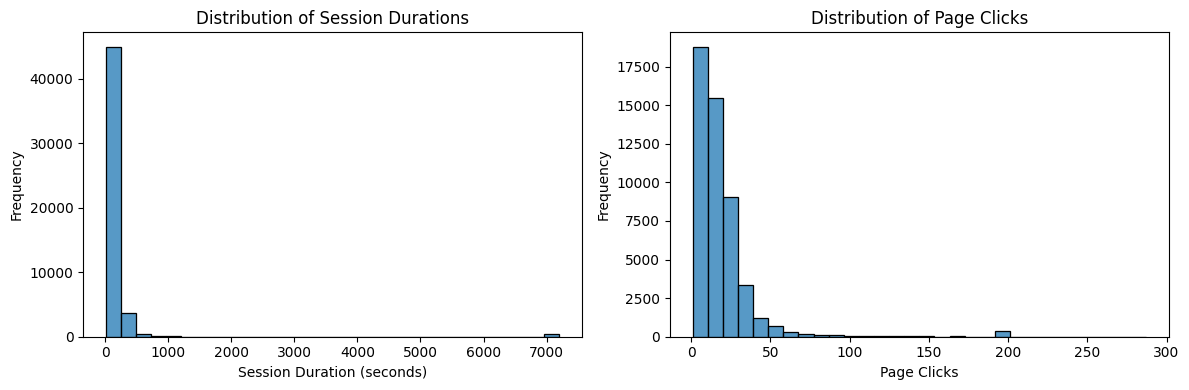

In [ ]:
sessions['duration_seconds'] = sessions['session_duration'].dt.total_seconds()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns

# Plot 1: Session Duration
sns.histplot(sessions['duration_seconds'], bins=30, edgecolor='black', ax=axes[0])
axes[0].set_xlabel('Session Duration (seconds)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Session Durations')

# Plot 2: Page Clicks
sns.histplot(sessions['page_clicks'], bins=30, edgecolor='black', ax=axes[1])
axes[1].set_xlabel('Page Clicks')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Page Clicks')

# Adjust layout
plt.tight_layout()
plt.show()

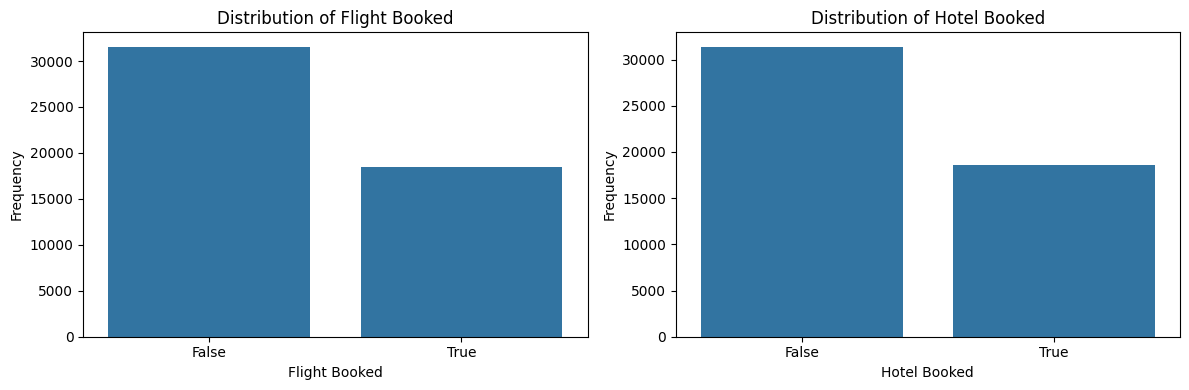

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot 1: Flight Booked
sns.countplot(x='flight_booked', data=sessions, ax=axes[0])
axes[0].set_xlabel('Flight Booked')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Flight Booked')

# Plot 2: Hotel Booked
sns.countplot(x='hotel_booked', data=sessions, ax=axes[1])
axes[1].set_xlabel('Hotel Booked')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Hotel Booked')

# Adjust layout
plt.tight_layout()
plt.show()

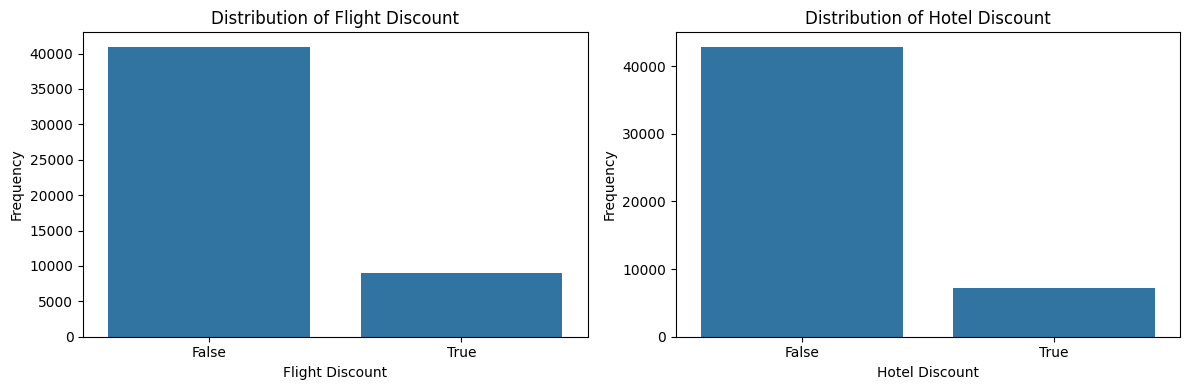

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns

# Plot 1: Flight Discount
sns.countplot(x='flight_discount', data=sessions, ax=axes[0])
axes[0].set_xlabel('Flight Discount')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Flight Discount')

# Plot 2: Hotel Discount
sns.countplot(x='hotel_discount', data=sessions, ax=axes[1])
axes[1].set_xlabel('Hotel Discount')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Hotel Discount')

# Adjust layout
plt.tight_layout()
plt.show()

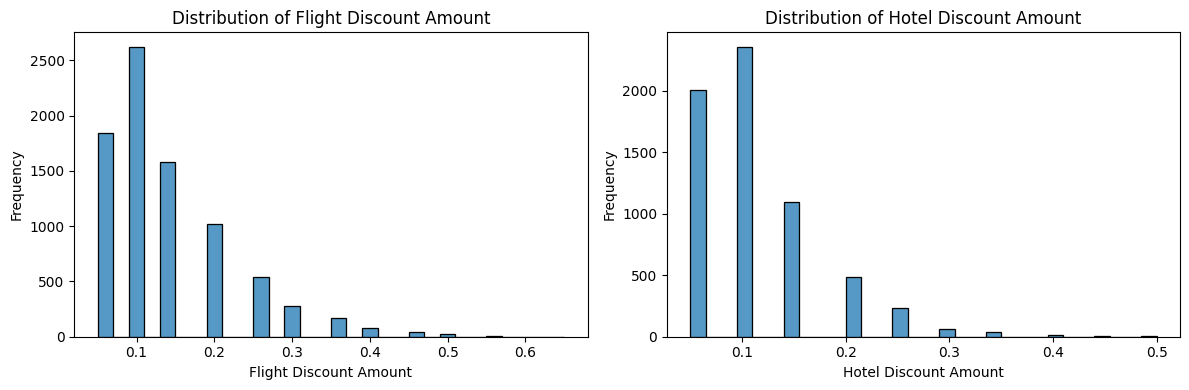

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns

# Plot 1: Flight Discount Amount
sns.histplot(sessions['flight_discount_amount'], bins=30, edgecolor='black', ax=axes[0])
axes[0].set_xlabel('Flight Discount Amount')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Flight Discount Amount')

# Plot 2: Hotel Discount Amount
sns.histplot(sessions['hotel_discount_amount'], bins=30, edgecolor='black', ax=axes[1])
axes[1].set_xlabel('Hotel Discount Amount')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Hotel Discount Amount')

# Adjust layout
plt.tight_layout()
plt.show()

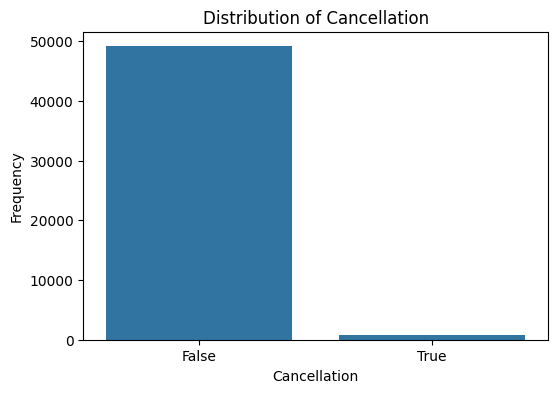

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x='cancellation', data=sessions)
plt.xlabel('Cancellation')
plt.ylabel('Frequency')
plt.title('Distribution of Cancellation')
plt.show()

# User Demographics

We check key demographics to understand the users of TravelTide.
* `gender`
* `marital status`
* `parental status`
* `home country`
* `home city`

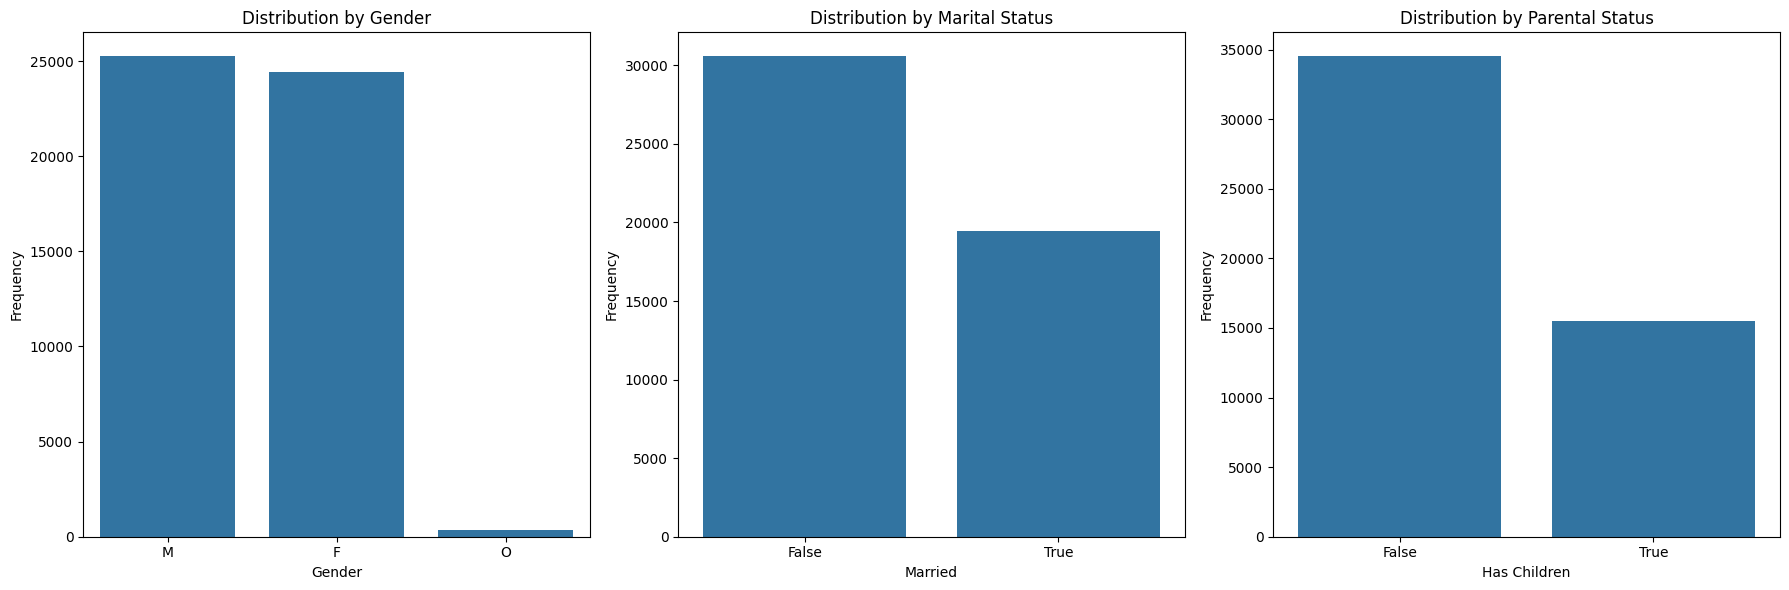

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

# Plot 1: Gender
sns.countplot(x='gender', data=sessions, ax=axes[0])
axes[0].set_title('Distribution by Gender')
axes[0].set_xlabel('Gender')
axes[0].set_ylabel('Frequency')

# Plot 2: Married
sns.countplot(x='married', data=sessions, ax=axes[1])
axes[1].set_title('Distribution by Marital Status')
axes[1].set_xlabel('Married')
axes[1].set_ylabel('Frequency')

# Plot 3: Has Children
sns.countplot(x='has_children', data=sessions, ax=axes[2])
axes[2].set_title('Distribution by Parental Status')
axes[2].set_xlabel('Has Children')
axes[2].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

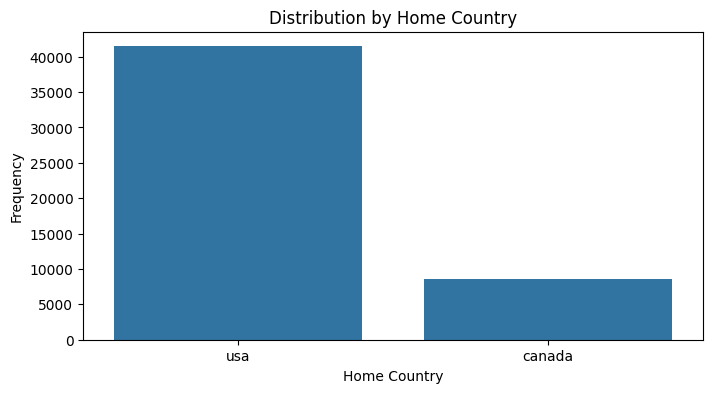

In [ ]:
plt.figure(figsize=(8, 4))
sns.countplot(x='home_country', data=sessions)
plt.xlabel('Home Country')
plt.ylabel('Frequency')
plt.title('Distribution by Home Country')
plt.show()

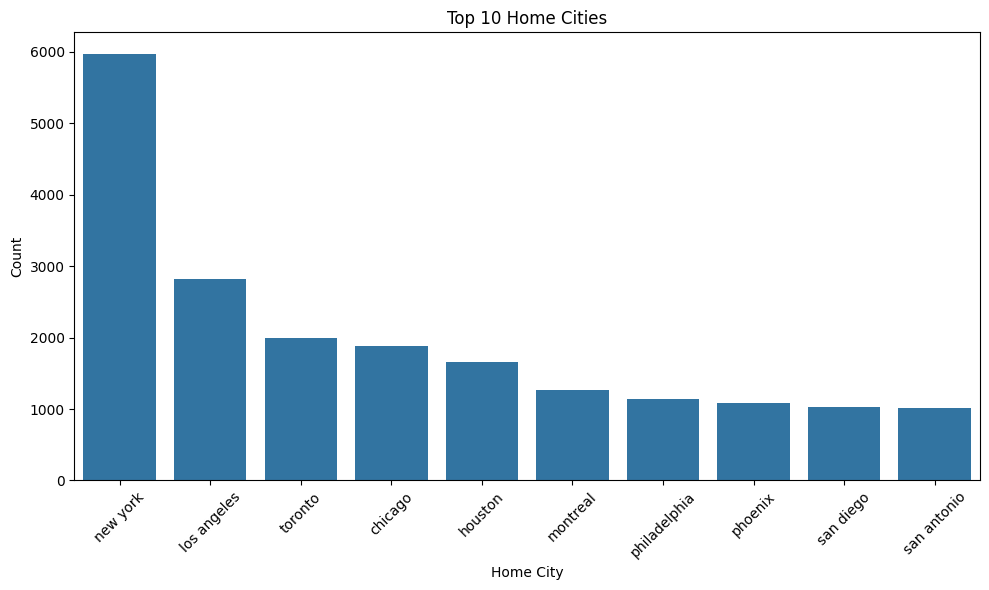

In [ ]:
# Get top 10 most frequent home cities
top_cities = sessions['home_city'].value_counts().nlargest(10).index

# Filter the DataFrame
top_sessions = sessions[sessions['home_city'].isin(top_cities)]

# Plot
plt.figure(figsize=(10, 6))
sns.countplot(data=top_sessions, x='home_city', order=top_cities)
plt.title('Top 10 Home Cities')
plt.xlabel('Home City')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Multivariate Analysis

We are looking for patterns and correlation between key features.

* `session duration` and `page clicks`
* `rooms` and `checked bags`
* `nights` and `checked bags`
* `base fare usd` and `flight discount`
* `hotel per room usd` and `hotel discount`
* `rooms` and `seats`

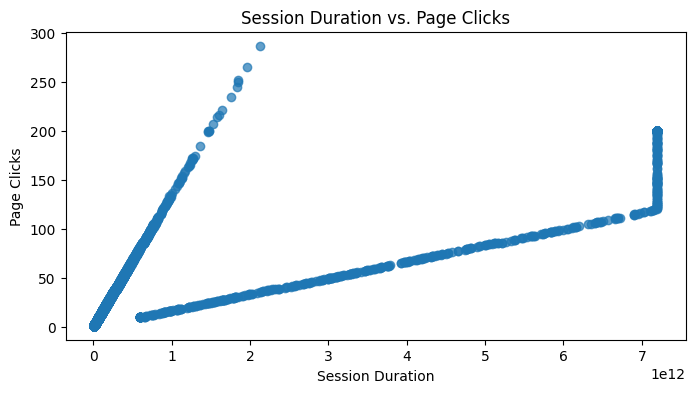

In [ ]:
plt.figure(figsize=(8, 4))
plt.scatter(sessions['session_duration'], sessions['page_clicks'], alpha=0.7)
plt.xlabel('Session Duration')
plt.ylabel('Page Clicks')
plt.title('Session Duration vs. Page Clicks')
plt.show()

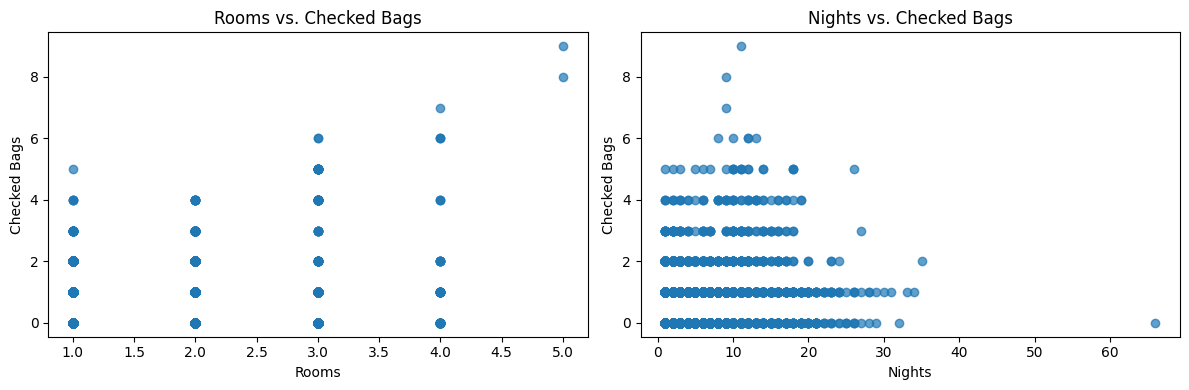

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot 1: Rooms vs. Checked Bags
axes[0].scatter(sessions['rooms'], sessions['checked_bags'], alpha=0.7)
axes[0].set_xlabel('Rooms')
axes[0].set_ylabel('Checked Bags')
axes[0].set_title('Rooms vs. Checked Bags')

# Plot 2: Nights vs. Checked Bags
axes[1].scatter(sessions['nights'], sessions['checked_bags'], alpha=0.7)
axes[1].set_xlabel('Nights')
axes[1].set_ylabel('Checked Bags')
axes[1].set_title('Nights vs. Checked Bags')

# Adjust layout
plt.tight_layout()
plt.show()

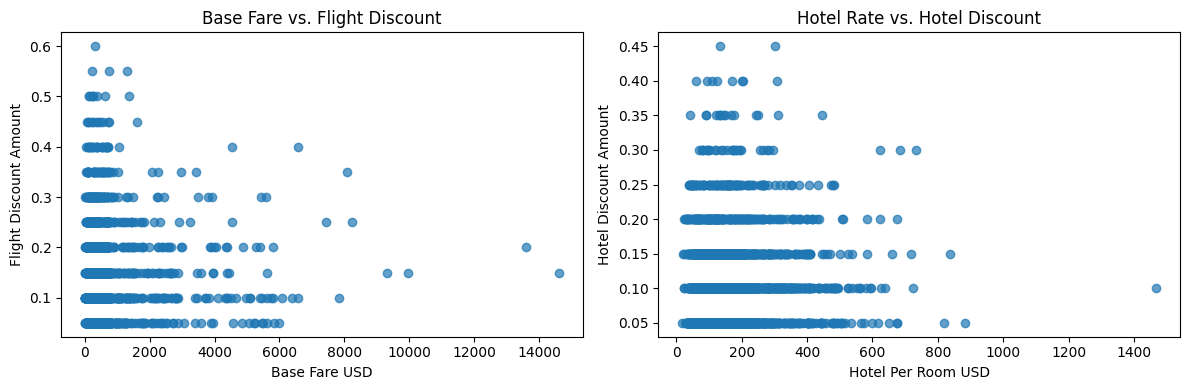

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot 1: Base Fare USD vs. Flight Discount Amount
axes[0].scatter(sessions['base_fare_usd'], sessions['flight_discount_amount'], alpha=0.7)
axes[0].set_xlabel('Base Fare USD')
axes[0].set_ylabel('Flight Discount Amount')
axes[0].set_title('Base Fare vs. Flight Discount')

# Plot 2: Hotel Per Room USD vs. Hotel Discount Amount
axes[1].scatter(sessions['hotel_per_room_usd'], sessions['hotel_discount_amount'], alpha=0.7)
axes[1].set_xlabel('Hotel Per Room USD')
axes[1].set_ylabel('Hotel Discount Amount')
axes[1].set_title('Hotel Rate vs. Hotel Discount')

# Adjust layout
plt.tight_layout()
plt.show()

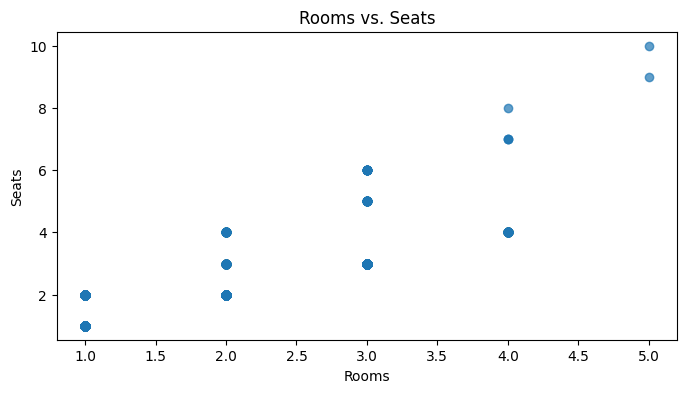

In [ ]:
plt.figure(figsize=(8, 4))
plt.scatter(sessions['rooms'], sessions['seats'], alpha=0.7)
plt.xlabel('Rooms')
plt.ylabel('Seats')
plt.title('Rooms vs. Seats')
plt.show()